On travaille sur le Dataset regularite-mensuelle-tgv-aqst qui rend compte de tous les retards moyens mensuels des trajets en TGV proposé par le SCNF depuis Janvier 2018.

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
url_retards ='https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC'
retards = requests.get(url_retards)
wb_retards = retards.json()

df_retards = pd.DataFrame(wb_retards)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,56,7.225734,29,11,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333


On commence par réorganiser notre Dataset. On divise la colonne 'date' en deux colonnes 'annee' et 'mois'. Puis on crée 2 nouvelles colonnes qui regarde le pourcentage de trains avec un depart au retard et le pourcentage de trains annulés.

In [3]:
df_retards['prct_nb_train_depart_retard'] = df_retards['nb_train_depart_retard']/df_retards['nb_train_prevu']*100
df_retards['prct_nb_annulation'] = df_retards['nb_annulation']/df_retards['nb_train_prevu']*100
df_retards[['annee','mois']]=df_retards.date.str.split('-',expand=True)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,prct_nb_train_depart_retard,prct_nb_annulation,annee,mois
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333,52.463054,0.246305,2018,01
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333,36.761905,0.571429,2018,01


On remarque que les colonnes des commentaires sont vides ou presque et ne nous interessent pas donc on peut les retirer. On retire également la colonne date étant donné que l'on vient juste de la diviser en deux colonnes annee et mois.

In [4]:
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)
df_retards['annee'] = pd.to_numeric(df_retards['annee'])
df_retards['mois'] = pd.to_numeric(df_retards['mois'])
df_retards.groupby(['date'])
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,prct_nb_train_depart_retard,prct_nb_annulation,annee,mois
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333,52.463054,0.246305,2018,1
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333,36.761905,0.571429,2018,1


Les données restantes sont presques toutes complètes et on peut commencer à les analyser. On peut commencer à regarder le taux de retard par mois selon les années observées.

On commence par créer la liste des moyennes du nombre de train en retard par mois pour chaque année observée. Puis on tracer les courbes de chaque année en fonction des mois afin de voir si une période de l'année est plus propice aux retards que d'autres.

In [5]:
df_retards_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_nb_train_depart_retard','mois']]
R_2018 = []
for i in range(12):
    df = df_retards_2018.loc[(df_retards_2018['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    R_2018.append(x)          

In [6]:
df_retards_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_nb_train_depart_retard','mois']]
R_2019 = []
for i in range(12):
    df = df_retards_2019.loc[(df_retards_2019['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    R_2019.append(x)          

In [7]:
df_retards_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_nb_train_depart_retard','mois']]
R_2020 = []
for i in range(12):
    df = df_retards_2020.loc[(df_retards_2020['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    R_2020.append(x)          

In [8]:
df_retards_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_nb_train_depart_retard','mois']]
R_2021 = []
for i in range(12):
    df = df_retards_2021.loc[(df_retards_2021['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    R_2021.append(x)          

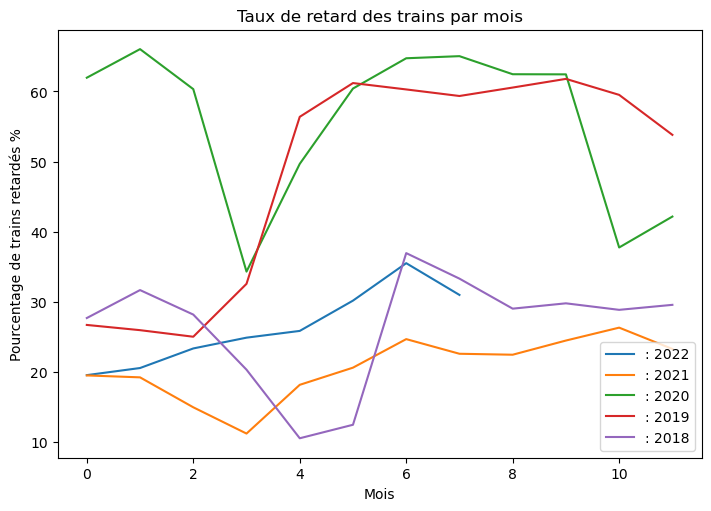

In [9]:
df_retards_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_nb_train_depart_retard','mois']]
R_2022 = []
for i in range(8):
    df = df_retards_2022.loc[(df_retards_2022['mois'] == i+1),['prct_nb_train_depart_retard']]
    x = np.mean(df['prct_nb_train_depart_retard'])
    R_2022.append(x)          

fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(R_2022, label=': 2022')
ax.plot(R_2021, label=': 2021')
ax.plot(R_2020, label=': 2020')
ax.plot(R_2019, label=': 2019')
ax.plot(R_2018, label=': 2018')
ax.set_xlabel('Mois')  
ax.set_ylabel('Pourcentage de trains retardés %') 
ax.set_title("Taux de retard des trains par mois")  
ax.legend()
plt.show()

On remarque que une tendance à la baisse des retards entre Février et Avril suivi d'une remontée jusqu'en Juin. Par ailleurs, les années 2019 et 2020 ont été particulièrement pénible au niveau des retards. Mais ça n'est pas forcément très clair donc on va tracer un unique graphe depuis Janvier-2018 à Août-2022.

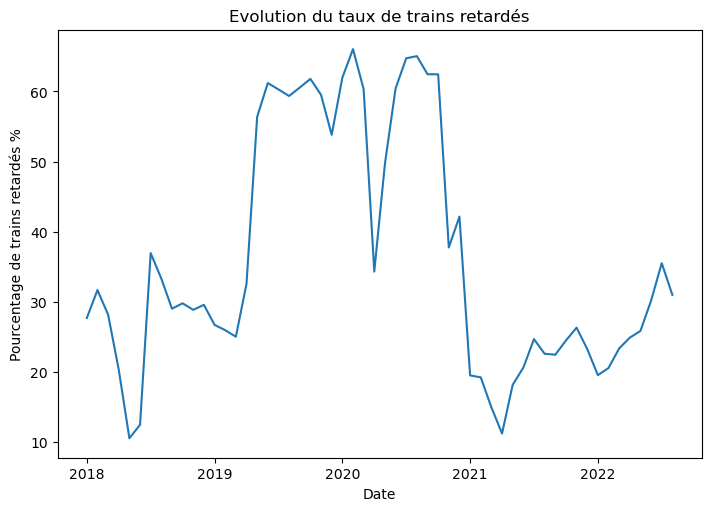

In [10]:
R = R_2018 + R_2019 + R_2020 + R_2021 + R_2022
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(R)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains retardés %') 
ax.set_title("Evolution du taux de trains retardés")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

On observe encore mieux l'effet cyclique des retards des trains. Au début de chaque nouvelle année, on observe une diminuation du pourcentage de trains en retards qui remonte à partir de la fin du premier tier de l'année. Maintenant, il serait intéressant de comparer le taux de retard avec le taux d'annulation pour voir si une baisse du taux de retard est en fait compensé par une augmentation du taux d'annulation ou non. On repète le même patern utilisé pour avoir la liste des taux de retard mensuels pour avoir les taux d'annulation mensuels.

In [11]:
df_annu_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_nb_annulation','mois']]
A_2018 = []
for i in range(12):
    df = df_annu_2018.loc[(df_annu_2018['mois'] == i+1),['prct_nb_annulation']]
    x = np.mean(df['prct_nb_annulation'])
    A_2018.append(x)    

In [12]:
df_annu_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_nb_annulation','mois']]
A_2019 = []
for i in range(12):
    df = df_annu_2019.loc[(df_annu_2019['mois'] == i+1),['prct_nb_annulation']]
    x = np.mean(df['prct_nb_annulation'])
    A_2019.append(x)

On remarque que quelques valeurs valent l'infini en 2020. C'est seulement du au fait qu'on ait divisé par 0 lors de la création de la colonne 'prct_nb_annulation'. On peut penser que certaines lignes ont été fermé en 2020 et donc le nombre de trains prévus étaient de 0. On remplace donc ces valeurs pas 0 (si il n'y a pas de train sur une ligne, il n'y a pas eu d'annulation.

In [13]:
df_annu_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_nb_annulation','mois']]
df_annu_2020[df_annu_2020['prct_nb_annulation'] == np.inf] = 0
A_2020 = []
for i in range(12):
    df = df_annu_2020.loc[(df_annu_2020['mois'] == i+1),['prct_nb_annulation']]
    x = np.mean(df['prct_nb_annulation'])
    A_2020.append(x)

In [14]:
df_annu_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_nb_annulation','mois']]
A_2021 = []
for i in range(12):
    df = df_annu_2021.loc[(df_annu_2021['mois'] == i+1),['prct_nb_annulation']]
    x = np.mean(df['prct_nb_annulation'])
    A_2021.append(x)

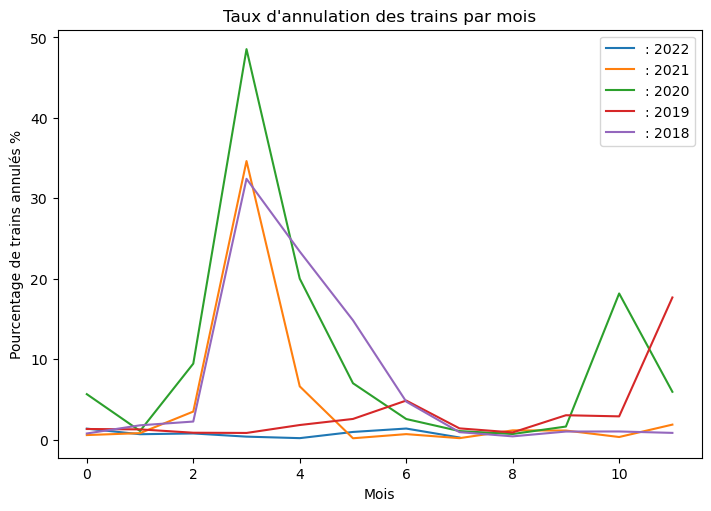

In [18]:
df_annu_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_nb_annulation','mois']]
A_2022 = []
for i in range(8):
    df = df_annu_2022.loc[(df_annu_2022['mois'] == i+1),['prct_nb_annulation']]
    x = np.mean(df['prct_nb_annulation'])
    A_2022.append(x)
    
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(A_2022, label=': 2022')
ax.plot(A_2021, label=': 2021')
ax.plot(A_2020, label=': 2020')
ax.plot(A_2019, label=': 2019')
ax.plot(A_2018, label=': 2018')
ax.set_xlabel('Mois')  
ax.set_ylabel('Pourcentage de trains annulés %') 
ax.set_title("Taux d\'annulation des trains par mois")  
ax.legend()
plt.show()    

Ici, on voit clairement qu'entre février et avril, il y a un pic du nombre d'annulation des trains. On affiche la courbe étalée sur toute la période pour rendre le phénomène encore un peu plus lisible.

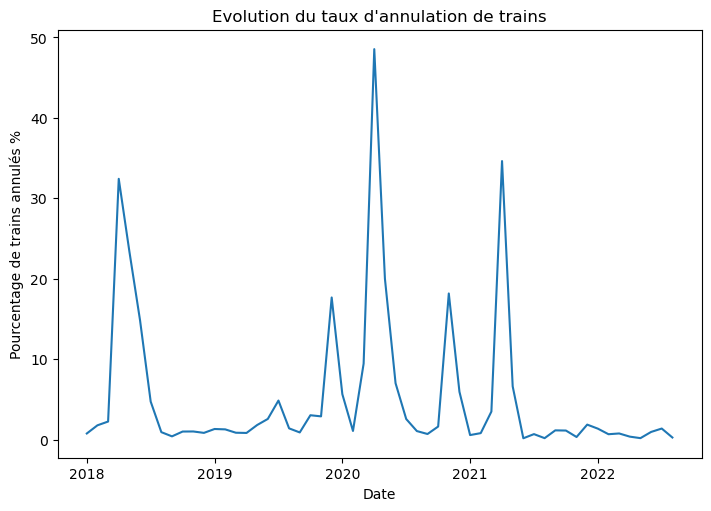

In [20]:
A = A_2018 + A_2019 + A_2020 + A_2021 + A_2022
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(A)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés %') 
ax.set_title("Evolution du taux d\'annulation de trains")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

C'est encore plus clair ici, en 2018, 2020 et 2021 on observe le même pic d'annulation en début d'année. Cela correspond ou même moment où on observait une baisse du taux de trains retardés. On peut donc afficher sur le même graphe l'évolution du taux d'annulation et de retard pour mettre en avant ce phénomène.

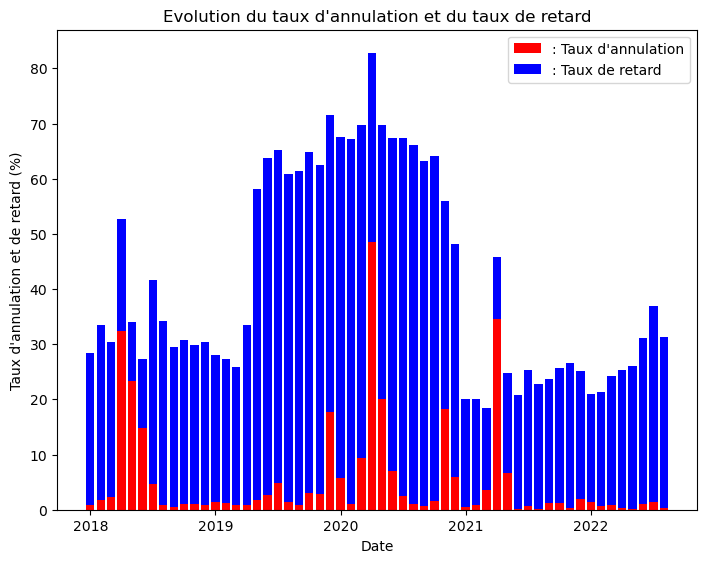

In [16]:
A = A_2018 + A_2019 + A_2020 + A_2021 + A_2022
ind = np.arange(len(A)) 
width = 0.8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, A, width, color='r')
ax.bar(ind, R, width,bottom=A, color='b')
ax.set_ylabel('Taux d\'annulation et de retard (%)')
ax.set_xlabel('Date')
ax.set_title('Evolution du taux d\'annulation et du taux de retard')
ax.legend(labels=[': Taux d\'annulation', ': Taux de retard'])
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

On remarque qu'en 2018, 2020 et 2021, le taux d'annulation de trains a augmenté considérablement aux alentours d'avril. Cela vient compenser l'effet observé sur l'analyse des seuls taux de retards. On avait remarqué que les retards diminués autour d'avril mais en même temps, les annulations deviennent beaucoup plus fréquentes. L'effet est d'autant plus visible que la baisse des retards est notables: en 2018, les retards étaient au plus bas en Avril, mais les annulations étaient au pic de leur fréquence. Pour 2019 ou 2022, on avait observé une diminution beaucoup plus faible des retards autour d'Avril, cela n'est donc pas étonnant de voir que les annulations restent beaucoup plus stables.

On peut maintenant s'intéresser aux causes des retards. Pour cela, on va comparer la proportion totale des différentes cause de retards au court du temps. Il faut donc obtenir 6 listes correspondant aux 6 causes de retard contenant les moyenes empiriques de chaque cause. Les 6 causes indiquées dans notre dataset sont les suivantes :
cause_externe                   
cause_infra                      
cause_gestion_trafic    
cause_materiel_roulant         
cause_gestion_gare             
cause_prise_en_charge_voyageurs  

On commence par regarder l'évolution de la cause "externe":

In [30]:
df_externe_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_cause_externe','mois']]
E_2018 = []
for i in range(12):
    df = df_externe_2018.loc[(df_externe_2018['mois'] == i+1),['prct_cause_externe']]
    x = np.mean(df['prct_cause_externe'])
    E_2018.append(x)

In [31]:
df_externe_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_cause_externe','mois']]
E_2019 = []
for i in range(12):
    df = df_externe_2019.loc[(df_externe_2019['mois'] == i+1),['prct_cause_externe']]
    x = np.mean(df['prct_cause_externe'])
    E_2019.append(x)

In [32]:
df_externe_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_cause_externe','mois']]
E_2020 = []
for i in range(12):
    df = df_externe_2020.loc[(df_externe_2020['mois'] == i+1),['prct_cause_externe']]
    x = np.mean(df['prct_cause_externe'])
    E_2020.append(x)

In [33]:
df_externe_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_cause_externe','mois']]
E_2021 = []
for i in range(12):
    df = df_externe_2021.loc[(df_externe_2021['mois'] == i+1),['prct_cause_externe']]
    x = np.mean(df['prct_cause_externe'])
    E_2021.append(x)

In [34]:
df_externe_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_cause_externe','mois']]
E_2022 = []
for i in range(8):
    df = df_externe_2022.loc[(df_externe_2022['mois'] == i+1),['prct_cause_externe']]
    x = np.mean(df['prct_cause_externe'])
    E_2022.append(x)

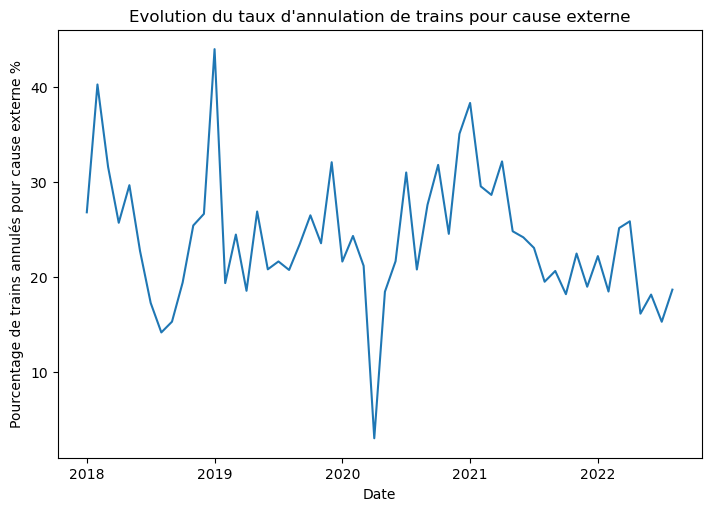

In [36]:
E = E_2018 + E_2019 + E_2020 + E_2021 + E_2022
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(E)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés pour cause externe %') 
ax.set_title("Evolution du taux d\'annulation de trains pour cause externe")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

In [37]:
df_infra_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_cause_infra','mois']]
I_2018 = []
for i in range(12):
    df = df_infra_2018.loc[(df_infra_2018['mois'] == i+1),['prct_cause_infra']]
    x = np.mean(df['prct_cause_infra'])
    I_2018.append(x)

In [38]:
df_infra_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_cause_infra','mois']]
I_2019 = []
for i in range(12):
    df = df_infra_2019.loc[(df_infra_2019['mois'] == i+1),['prct_cause_infra']]
    x = np.mean(df['prct_cause_infra'])
    I_2019.append(x)

In [39]:
df_infra_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_cause_infra','mois']]
I_2020 = []
for i in range(12):
    df = df_infra_2020.loc[(df_infra_2020['mois'] == i+1),['prct_cause_infra']]
    x = np.mean(df['prct_cause_infra'])
    I_2020.append(x)

In [40]:
df_infra_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_cause_infra','mois']]
I_2021 = []
for i in range(12):
    df = df_infra_2021.loc[(df_infra_2021['mois'] == i+1),['prct_cause_infra']]
    x = np.mean(df['prct_cause_infra'])
    I_2021.append(x)

In [41]:
df_infra_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_cause_infra','mois']]
I_2022 = []
for i in range(8):
    df = df_infra_2022.loc[(df_infra_2022['mois'] == i+1),['prct_cause_infra']]
    x = np.mean(df['prct_cause_infra'])
    I_2022.append(x)

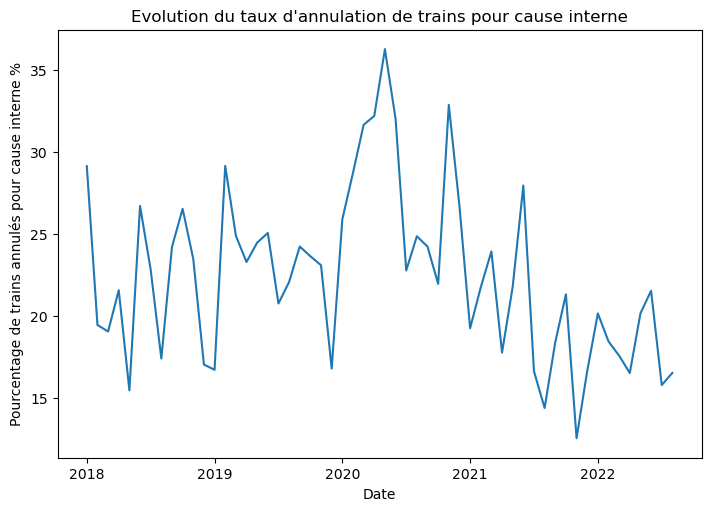

In [43]:
I = I_2018 + I_2019 + I_2020 + I_2021 + I_2022
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(I)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés pour cause interne %') 
ax.set_title("Evolution du taux d\'annulation de trains pour cause interne")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

In [44]:
df_gestion_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_cause_gestion_trafic','mois']]
G_2018 = []
for i in range(12):
    df = df_gestion_2018.loc[(df_gestion_2018['mois'] == i+1),['prct_cause_gestion_trafic']]
    x = np.mean(df['prct_cause_gestion_trafic'])
    G_2018.append(x)

In [45]:
df_gestion_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_cause_gestion_trafic','mois']]
G_2019 = []
for i in range(12):
    df = df_gestion_2019.loc[(df_gestion_2019['mois'] == i+1),['prct_cause_gestion_trafic']]
    x = np.mean(df['prct_cause_gestion_trafic'])
    G_2019.append(x)

In [46]:
df_gestion_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_cause_gestion_trafic','mois']]
G_2020 = []
for i in range(12):
    df = df_gestion_2020.loc[(df_gestion_2020['mois'] == i+1),['prct_cause_gestion_trafic']]
    x = np.mean(df['prct_cause_gestion_trafic'])
    G_2020.append(x)

In [47]:
df_gestion_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_cause_gestion_trafic','mois']]
G_2021 = []
for i in range(12):
    df = df_gestion_2021.loc[(df_gestion_2021['mois'] == i+1),['prct_cause_gestion_trafic']]
    x = np.mean(df['prct_cause_gestion_trafic'])
    G_2021.append(x)

In [48]:
df_gestion_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_cause_gestion_trafic','mois']]
G_2022 = []
for i in range(8):
    df = df_gestion_2022.loc[(df_gestion_2022['mois'] == i+1),['prct_cause_gestion_trafic']]
    x = np.mean(df['prct_cause_gestion_trafic'])
    G_2022.append(x)

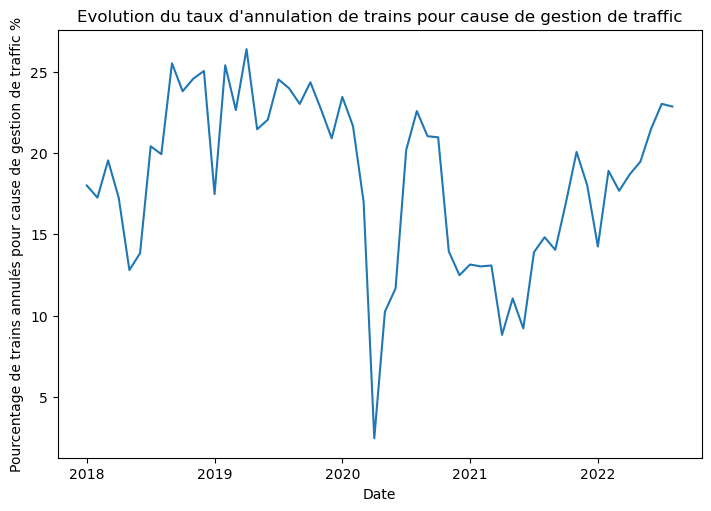

In [49]:
G = G_2018 + G_2019 + G_2020 + G_2021 + G_2022
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(G)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés pour cause de gestion de traffic %') 
ax.set_title("Evolution du taux d\'annulation de trains pour cause de gestion de traffic")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

In [59]:
df_materiel_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_cause_materiel_roulant','mois']]
M_2018 = []
for i in range(12):
    df = df_materiel_2018.loc[(df_materiel_2018['mois'] == i+1),['prct_cause_materiel_roulant']]
    x = np.mean(df['prct_cause_materiel_roulant'])
    M_2018.append(x)

In [60]:
df_materiel_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_cause_materiel_roulant','mois']]
M_2019 = []
for i in range(12):
    df = df_materiel_2019.loc[(df_materiel_2019['mois'] == i+1),['prct_cause_materiel_roulant']]
    x = np.mean(df['prct_cause_materiel_roulant'])
    M_2019.append(x)

In [61]:
df_materiel_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_cause_materiel_roulant','mois']]
M_2020 = []
for i in range(12):
    df = df_materiel_2020.loc[(df_materiel_2020['mois'] == i+1),['prct_cause_materiel_roulant']]
    x = np.mean(df['prct_cause_materiel_roulant'])
    M_2020.append(x)

In [62]:
df_materiel_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_cause_materiel_roulant','mois']]
M_2021 = []
for i in range(12):
    df = df_materiel_2021.loc[(df_materiel_2021['mois'] == i+1),['prct_cause_materiel_roulant']]
    x = np.mean(df['prct_cause_materiel_roulant'])
    M_2021.append(x)

In [63]:
df_materiel_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_cause_materiel_roulant','mois']]
M_2022 = []
for i in range(8):
    df = df_materiel_2022.loc[(df_materiel_2022['mois'] == i+1),['prct_cause_materiel_roulant']]
    x = np.mean(df['prct_cause_materiel_roulant'])
    M_2022.append(x)

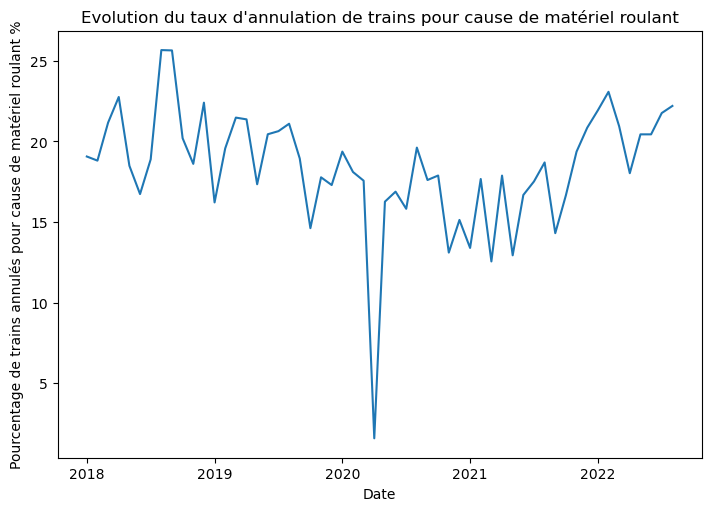

In [65]:
M = M_2018 + M_2019 + M_2020 + M_2021 + M_2022
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(M)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés pour cause de matériel roulant %') 
ax.set_title("Evolution du taux d\'annulation de trains pour cause de matériel roulant")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

In [66]:
df_gestionG_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_cause_gestion_gare','mois']]
GG_2018 = []
for i in range(12):
    df = df_gestionG_2018.loc[(df_gestionG_2018['mois'] == i+1),['prct_cause_gestion_gare']]
    x = np.mean(df['prct_cause_gestion_gare'])
    GG_2018.append(x)

In [67]:
df_gestionG_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_cause_gestion_gare','mois']]
GG_2019 = []
for i in range(12):
    df = df_gestionG_2019.loc[(df_gestionG_2019['mois'] == i+1),['prct_cause_gestion_gare']]
    x = np.mean(df['prct_cause_gestion_gare'])
    GG_2019.append(x)

In [68]:
df_gestionG_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_cause_gestion_gare','mois']]
GG_2020 = []
for i in range(12):
    df = df_gestionG_2020.loc[(df_gestionG_2020['mois'] == i+1),['prct_cause_gestion_gare']]
    x = np.mean(df['prct_cause_gestion_gare'])
    GG_2020.append(x)

In [69]:
df_gestionG_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_cause_gestion_gare','mois']]
GG_2021 = []
for i in range(12):
    df = df_gestionG_2021.loc[(df_gestionG_2021['mois'] == i+1),['prct_cause_gestion_gare']]
    x = np.mean(df['prct_cause_gestion_gare'])
    GG_2021.append(x)

In [70]:
df_gestionG_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_cause_gestion_gare','mois']]
GG_2022 = []
for i in range(8):
    df = df_gestionG_2022.loc[(df_gestionG_2022['mois'] == i+1),['prct_cause_gestion_gare']]
    x = np.mean(df['prct_cause_gestion_gare'])
    GG_2022.append(x)

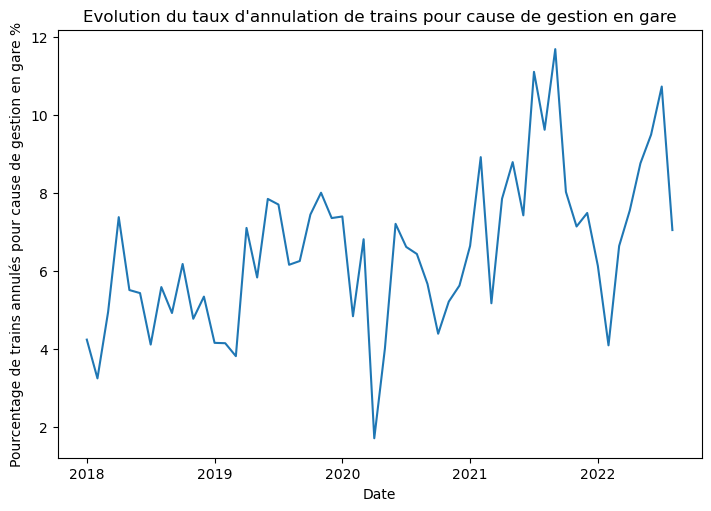

In [72]:
GG = GG_2018 + GG_2019 + GG_2020 + GG_2021 + GG_2022
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(GG)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés pour cause de gestion en gare %') 
ax.set_title("Evolution du taux d\'annulation de trains pour cause de gestion en gare")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

In [73]:
df_voyageurs_2018 = df_retards.loc[(df_retards['annee'] == 2018),['prct_cause_prise_en_charge_voyageurs','mois']]
V_2018 = []
for i in range(12):
    df = df_voyageurs_2018.loc[(df_voyageurs_2018['mois'] == i+1),['prct_cause_prise_en_charge_voyageurs']]
    x = np.mean(df['prct_cause_prise_en_charge_voyageurs'])
    V_2018.append(x)

In [74]:
df_voyageurs_2019 = df_retards.loc[(df_retards['annee'] == 2019),['prct_cause_prise_en_charge_voyageurs','mois']]
V_2019 = []
for i in range(12):
    df = df_voyageurs_2019.loc[(df_voyageurs_2019['mois'] == i+1),['prct_cause_prise_en_charge_voyageurs']]
    x = np.mean(df['prct_cause_prise_en_charge_voyageurs'])
    V_2019.append(x)

In [75]:
df_voyageurs_2020 = df_retards.loc[(df_retards['annee'] == 2020),['prct_cause_prise_en_charge_voyageurs','mois']]
V_2020 = []
for i in range(12):
    df = df_voyageurs_2020.loc[(df_voyageurs_2020['mois'] == i+1),['prct_cause_prise_en_charge_voyageurs']]
    x = np.mean(df['prct_cause_prise_en_charge_voyageurs'])
    V_2020.append(x)

In [76]:
df_voyageurs_2021 = df_retards.loc[(df_retards['annee'] == 2021),['prct_cause_prise_en_charge_voyageurs','mois']]
V_2021 = []
for i in range(12):
    df = df_voyageurs_2021.loc[(df_voyageurs_2021['mois'] == i+1),['prct_cause_prise_en_charge_voyageurs']]
    x = np.mean(df['prct_cause_prise_en_charge_voyageurs'])
    V_2021.append(x)

In [77]:
df_voyageurs_2022 = df_retards.loc[(df_retards['annee'] == 2022),['prct_cause_prise_en_charge_voyageurs','mois']]
V_2022 = []
for i in range(8):
    df = df_voyageurs_2022.loc[(df_voyageurs_2022['mois'] == i+1),['prct_cause_prise_en_charge_voyageurs']]
    x = np.mean(df['prct_cause_prise_en_charge_voyageurs'])
    V_2022.append(x)

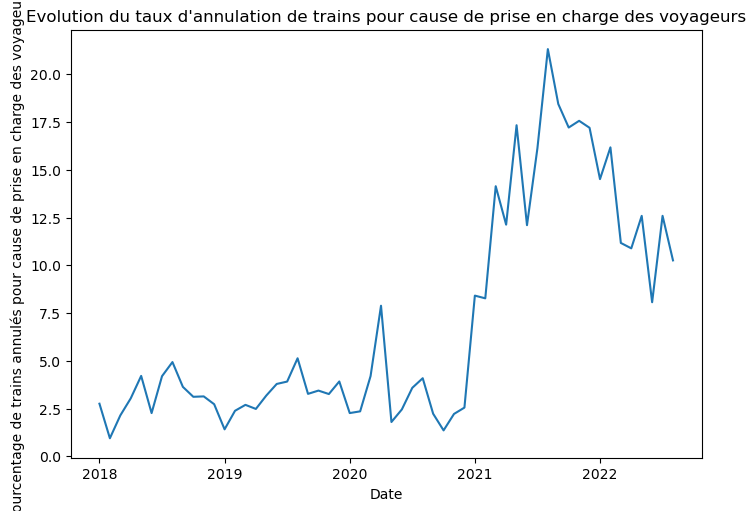

In [78]:
V = V_2018 + V_2019 + V_2020 + V_2021 + V_2022
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(V)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés pour cause de prise en charge des voyageurs %') 
ax.set_title("Evolution du taux d\'annulation de trains pour cause de prise en charge des voyageurs")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

On observe l'évolution de la proportion des causes de retards depuis 2018 mais chaque graphe n'est pas très clair et on voudrait les regrouper sur un seul afin d'avoir une meilleure idée des phénomènes en action.

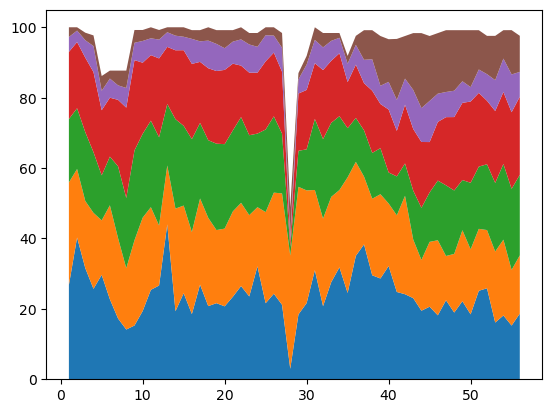

In [84]:
C = [E, I, G, M, GG, V]
inde = range(1,57)
fig, ax = plt.subplots()

ax.stackplot(inde, C)

plt.show()